# Gradient Boosting

In [1]:
# Base
from typing import Tuple
import pandas as pd
import numpy as np
import gc
import time
from tqdm import tqdm
import sys
sys.path.append('../../')


# Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Modeling
from sklearn.linear_model import SGDClassifier

# Scoring
from scoring.event_detection_matrix import competition_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Filereading
import pyarrow.parquet as pq

## Datei laden

In [2]:
train_file = pq.ParquetFile('../../data/processed/train_series_split.parquet')

## Hyperparams

In [3]:
RANDOM_STATE = 42
features = ['anglez', 'enmo',
            'hour',
            'anglez_abs', 'anglez_diff', 'enmo_diff', 'anglez_x_enmo',
            'anglez_rolling_mean', 'enmo_rolling_mean', 'anglez_rolling_max', 'enmo_rolling_max', 'anglez_rolling_min',
            'anglez_rolling_std', 'enmo_rolling_std']
target_column = ['awake']


## Pipeline

In [4]:
scaler = StandardScaler()
clf = SGDClassifier(random_state=RANDOM_STATE,loss="modified_huber")

## Datenaufbereitung & Training

In [5]:
start_time = time.time()

for batch in tqdm(train_file.iter_batches(batch_size=655360)):
    train = batch.to_pandas()
    train = train.drop(columns=['series_id', 'step', 'timestamp'])
    X_train = train[features]
    y_train = train[target_column]
    scaler.partial_fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    clf.partial_fit(X_train_scaled, y_train.values.ravel(), classes=[0,1])
    
print(f'Training took {time.time() - start_time} seconds')

151it [05:14,  2.08s/it]

Training took 314.3323576450348 seconds


## Free Space

In [6]:
del train
del X_train
del y_train

## Prediction

In [7]:
validation = pd.read_parquet('../../data/processed/validation_series_split.parquet')
validation_events = pd.read_csv('../../data/processed/validation_events_split.csv')

In [8]:
X_validation = validation[features]
y_validation = validation[target_column]

In [9]:
start_time = time.time()

label_pred_list = []
confidence_0_pred_list = []
confidence_1_pred_list = []

for series_id in tqdm(validation.series_id.unique()):
    validation_chunk = validation[validation.series_id == series_id]
    X_validation_chunk = validation_chunk[features]
    scaled_X = scaler.transform(X_validation_chunk)
    pred_chunk = clf.predict(scaled_X)
    pred_proba_chunk = clf.predict_proba(scaled_X)
    pred_0_proba_chunk = pred_proba_chunk[:, 0]
    pred_1_proba_chunk = pred_proba_chunk[:, 1]

    label_pred_list.append(pred_chunk)
    confidence_0_pred_list.append(pred_0_proba_chunk)
    confidence_1_pred_list.append(pred_1_proba_chunk)
    
    del X_validation_chunk
    del pred_proba_chunk
    del pred_0_proba_chunk
    del pred_1_proba_chunk

    gc.collect()

label_pred_list = np.concatenate(label_pred_list)
confidence_0_pred_list = np.concatenate(confidence_0_pred_list)
confidence_1_pred_list = np.concatenate(confidence_1_pred_list)

print(f'Prediction took {time.time() - start_time} seconds')

100%|██████████| 54/54 [01:49<00:00,  2.03s/it]


Prediction took 111.543301820755 seconds


In [10]:
print(label_pred_list.shape)
print(y_validation.shape)

(26187300,)
(26187300, 1)


In [11]:
validation['prediction_class'] = label_pred_list
validation['prediction_confidence_0'] = confidence_0_pred_list
validation['prediction_confidence_1'] = confidence_1_pred_list

In [12]:
validation = validation[['series_id', 'step', 'timestamp', 'awake', 'prediction_class', 'prediction_confidence_0', 'prediction_confidence_1']]
validation

,series_id,step,timestamp,awake,prediction_class,prediction_confidence_0,prediction_confidence_1
2992140,062dbd4c95e6,0,2018-08-22T12:15:00-0400,1,1,0.000000,1.000000
2992141,062dbd4c95e6,1,2018-08-22T12:15:05-0400,1,1,0.000000,1.000000
2992142,062dbd4c95e6,2,2018-08-22T12:15:10-0400,1,1,0.000000,1.000000
2992143,062dbd4c95e6,3,2018-08-22T12:15:15-0400,1,1,0.000000,1.000000
2992144,062dbd4c95e6,4,2018-08-22T12:15:20-0400,1,1,0.000000,1.000000
...,...,...,...,...,...,...,...
124229695,fcca183903b7,620635,2019-05-01T10:59:35-0400,1,0,0.947718,0.052282
124229696,fcca183903b7,620636,2019-05-01T10:59:40-0400,1,0,0.947718,0.052282
124229697,fcca183903b7,620637,2019-05-01T10:59:45-0400,1,0,0.947718,0.052282
124229698,fcca183903b7,620638,2019-05-01T10:59:50-0400,1,0,0.947718,0.052282


## Evaluate

### Accuracy

In [13]:
accuracy_score(y_validation, label_pred_list)

0.7910043799857183

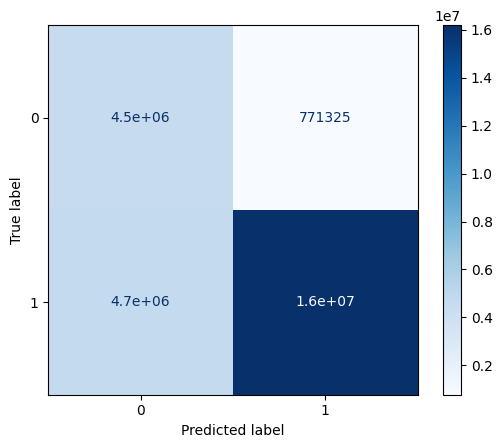

In [14]:
cm = confusion_matrix(y_validation, label_pred_list)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

### Competition Score

In [21]:
def get_events_smoothed(test_series) :
    series_ids = test_series['series_id'].unique()
    events = []
    wakeups = []
    onsets = []
    
    for idx in tqdm(series_ids):
        # Collecting sample and normalizing features
        X = test_series[test_series.series_id == idx]
                
        smoothing_length = 12 * 30 # 30 Minutes
        X["score"] = X["prediction_confidence_1"].rolling(smoothing_length, center=True).mean().bfill().ffill()
        X["smooth"] = X["prediction_confidence_0"].rolling(smoothing_length, center=True).mean().bfill().ffill()

        # Binarize the smoothing column
        X["smooth"] = X["smooth"].round()

        # Getting predicted onset and wakeup time steps
        pred_onsets = X[X['smooth'].diff() > 0]['step'].tolist()
        pred_wakeups = X[X['smooth'].diff() < 0]['step'].tolist()
     
        if len(pred_onsets) > 0 : 

            # Ensuring all predicted sleep periods begin and end
            if min(pred_wakeups) < min(pred_onsets) : 
                pred_wakeups = pred_wakeups[1:]

            if max(pred_onsets) > max(pred_wakeups) :
                pred_onsets = pred_onsets[:-1]

            # Keeping sleep periods longer than 30 minutes
            sleep_periods = [(onset, wakeup) for onset, wakeup in zip(pred_onsets, pred_wakeups) if wakeup - onset >= 12 * 30]

            for onset, wakeup in sleep_periods :
                # Scoring using mean probability over period
                score = X[(X['step'] >= onset) & (X['step'] <= wakeup)]['score'].mean()

                # Adding sleep event to dataframe
                onset_row = {'row_id': len(events), 'series_id': idx, 'step': onset, 'event': 'onset', 'score': score, 'timestamp': X[X['step']==onset].iloc[0].timestamp}                
                events.append(onset_row)

                wakeup_row = {'row_id': len(events), 'series_id': idx, 'step': wakeup, 'event': 'wakeup', 'score': score, 'timestamp': X[X['step']==wakeup].iloc[0].timestamp}
                events.append(wakeup_row)

    df_events = pd.DataFrame(events)

    filtered_events = pd.DataFrame()
    for idx in series_ids:
        current_events = df_events[df_events['series_id'] == idx]
        test_wakeup = current_events[current_events['event']=='wakeup'].groupby(current_events['timestamp'].str[0:10]).agg('first')
        test_onset = current_events[current_events['event']=='onset'].groupby(current_events['timestamp'].str[0:10]).agg('last')
        filtered_events = pd.concat([filtered_events, test_wakeup, test_onset], ignore_index=True).sort_values('timestamp')
        
    return df_events

In [22]:
predicted_validation_events = get_events_smoothed(validation)

  0%|          | 0/54 [00:00<?, ?it/s]C:\Users\oliko\AppData\Local\Temp\ipykernel_25796\109253675.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["score"] = X["prediction_confidence_1"].rolling(smoothing_length, center=True).mean().bfill().ffill()
C:\Users\oliko\AppData\Local\Temp\ipykernel_25796\109253675.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["smooth"] = X["prediction_confidence_0"].rolling(smoothing_length, center=True).mean().bfill().ffill()
C:\Users\oliko\AppData\Local\Temp\ipyke

In [23]:
predicted_validation_events

,row_id,series_id,step,event,score,timestamp
0,272,10f8bc1f7b07,7833,onset,0.157784,2017-09-07T23:37:45-0400
1,273,10f8bc1f7b07,13574,wakeup,0.157784,2017-09-08T07:36:10-0400
2,274,10f8bc1f7b07,24978,onset,0.259709,2017-09-08T23:26:30-0400
3,275,10f8bc1f7b07,32036,wakeup,0.259709,2017-09-09T09:14:40-0400
4,276,10f8bc1f7b07,42589,onset,0.214310,2017-09-09T23:54:05-0400
...,...,...,...,...,...,...
2905,2085,72d2234e84e4,515482,wakeup,0.185416,2019-06-13T08:26:50-0400
2906,2086,72d2234e84e4,526579,onset,0.155543,2019-06-13T23:51:35-0400
2907,2087,72d2234e84e4,531458,wakeup,0.155543,2019-06-14T06:38:10-0400
2908,2088,72d2234e84e4,543859,onset,0.155543,2019-06-14T23:51:35-0400


In [24]:
competition_score(validation_events, predicted_validation_events)

0.054475918008994616

In [25]:
validation.to_parquet('./data/predicted_series_dt.parquet')

In [26]:
predicted_validation_events.to_csv('./data/predicted_events.csv', index=False)